# Disparity Estimation

In [3]:
import numpy as np
import numba as nb
import cv2
import matplotlib.pyplot as plt
from utils import plots
from utils import imgs
from tqdm import tqdm

In [4]:
I1, I2 = cv2.imread('images/tsukubaL.ppm', 0) / 255.0, cv2.imread('images/tsukubaR.ppm', 0) / 255.0

In [5]:
@nb.njit
def cost_matrix(I1, I2, w=5, n=15):
    cost = np.ones((*I1.shape, n*2-1)) * (-np.inf)
    
    p1 = np.zeros((I1.shape[0] + w, I1.shape[1] + w))
    p1[w//2:-w//2, w//2:-w//2] = I1.copy()
    
    
    p2 = np.zeros((I2.shape[0] + w, I2.shape[1] + w))
    p2[w//2:-w//2, w//2:-w//2] = I2.copy()
    
    for i in range(I1.shape[0]):
        for j in range(I2.shape[1]):
            for k in range(max(0, j-n+1)-j, min(I1.shape[1], j+n)-j):
                templ = p1[i:i+w, j:j+w]
                targt = p2[i:i+w, j+k:j+k+w]
                
                num = ((templ - templ.mean()) * (targt - targt.mean())).mean()
                den = np.sqrt(templ.var() * targt.var())
            
                cost[i, j, k+n-1] = num / (den + 0.001)
    return cost

In [6]:
def disparity(I1, I2, w=5, n=15, pwcost=None):
    
    
    pwcost = pwcost if pwcost is not None else np.eye(2*n-1)
    cost = cost_matrix(I1, I2, w, n)
    
    # Number of labels
    n = cost.shape[2]
    
    forw = np.zeros_like(cost)
    back = np.zeros_like(cost)
    
    forw[:,  0, :] = 0.0
    back[:, -1, :] = 0.0
    
    for i in range(1, I1.shape[1]):
        
        # Forward pass
        forw[:,    i] = np.amax(forw[:, None, i-1] + cost[:, None, i-1] + pwcost, axis=2)
        
        # Backward pass
        back[:, -i-1] = np.amax(back[:, None,  -i] + cost[:, None,  -i] + pwcost, axis=2)
    
    return np.argmax(forw + back + cost, axis=2) - n
        


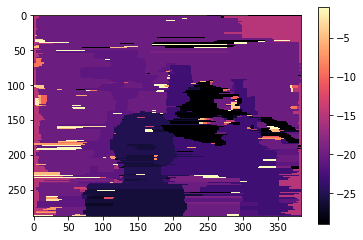

In [7]:
res = disparity(I1, I2)
plt.imshow(res, cmap='magma')
plt.colorbar()

In [18]:
def SGMdisparity(I1, I2, w=5, n=15, pwcost=None):
    
    
    pwcost = pwcost if pwcost is not None else np.eye(2*n-1)
    cost = cost_matrix(I1, I2, w, n)
    
    # Number of labels
    n = cost.shape[2]
    
    forw = np.zeros((*I1.shape, 4, 29))
    back = np.zeros((*I1.shape, 4, 29))
    
    for i in range(0, I1.shape[0]):
        for j in range(0, I1.shape[1]):
            
            ### FORWARD
            
            # Top Left
            if i>0 and j>0:
                forw[i, j, 0] = np.amax(forw[i-1, j-1, 0] + cost[i-1, j-1] + pwcost, axis=1)
                
            # Top
            if i>0:
                forw[i, j, 1] = np.amax(forw[i-1, j, 1] + cost[i-1, j] + pwcost, axis=1)     
                
            # Top Right
            if i>0 and j<I1.shape[1]-1:
                forw[i, j, 2] = np.amax(forw[i-1, j+1, 2] + cost[i-1, j+1] + pwcost, axis=1)  
                
            # Left
            if j>0:
                forw[i, j, 3] = np.amax(forw[i, j-1, 3] + cost[i, j-1] + pwcost, axis=1)  
                
            
            ### BACKWARD
            
            # Bottom Right
            if i<I1.shape[0]-1 and j<I1.shape[1]-1:
                back[i, j, 0] = np.amax(back[i+1, j+1, 0] + cost[i+1, j+1] + pwcost, axis=1)
                
            # Bottom
            if i<I1.shape[0]-1:
                back[i, j, 1] = np.amax(back[i+1, j, 1] + cost[i+1, j] + pwcost, axis=1)
                
            # Bottom Left
            if i<I1.shape[0]-1 and j>0:
                back[i, j, 2] = np.amax(back[i+1, j-1, 2] + cost[i+1, j-1] + pwcost, axis=1)
                
            # Right
            if j<I1.shape[1]-1:
                back[i, j, 3] = np.amax(back[i, j+1, 3] + cost[i, j+1] + pwcost, axis=1)
                
                
    
    return np.argmax(forw.sum(axis=2) + back.sum(axis=2) + cost, axis=2) - n


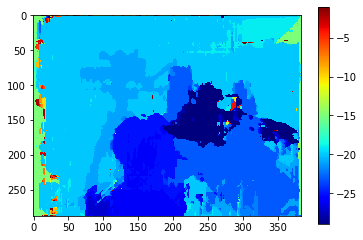

In [31]:

pw = np.eye(29) * 2.0
pw[np.arange(1, 29), np.arange(0, 28)] = 1.5
pw[np.arange(0, 28), np.arange(1, 29)] = 1.5
        
res = SGMdisparity(I1, I2, w=5, pwcost=pw)
plt.imshow(res, cmap='jet')
plt.colorbar()

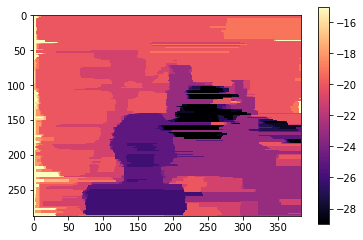

In [30]:
n = 15

pw = np.zeros((2*n-1, 2*n-1))
for i in range(2*n-1):
    for j in range(2*n-1):
        pw[i, j] = 1 - np.abs(i-j) / np.sqrt(2)

        
        
res = disparity(I1, I2, n=n, pwcost=pw)
plt.imshow(res, cmap='magma')
plt.colorbar()